<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd%20(further%20work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To suppress tokenizer parallelism warnings

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

In [3]:
!pip install datasketch
from datasketch import MinHash, MinHashLSH
from datasets import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 2.2 MB/s eta 0:00:00


In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

In [5]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
import torch
import torch.nn as nn

In [6]:
import warnings
from transformers import logging
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

In [7]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Data Loading

In [8]:
!pip install pyarrow

In [9]:
df = pd.read_parquet("0000.parquet")  # Let pandas choose the engine
df.head()

,document_name,words,pos_tags,met_type,meta
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[],"[N/A, N/A, N/A]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t...","[N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, N/A, ..."


In [10]:
df = df.iloc[:, :-1]  # dropping the last column

In [11]:
# Extract unique metaphor type values
unique_types = set(
    t['type']
    for row in df['met_type'].dropna()
    for t in row
)

print(unique_types)

{'mFlag/phrase', 'mrw/met', 'mrw/lit/WIDLII', 'mFlag/lex/WIDLII', 'mrw/met/ANIM', 'mFlag/morph', 'mrw/met/UNKNOWN', 'mrw/lit', 'mrw/met/WIDLII', 'mrw/bridge', 'mrw/met/PP', 'mrw/met/OMM', 'mrw/impl/WIDLII', 'mFlag/lex', 'mrw/impl', 'mFlag/phrase/WIDLII', 'mrw/met/M', 'mrw/met/double'}


In [12]:
allowed_types = {'mrw/met', 'mrw/lit', 'mrw/impl', 'mrw/met/double'}
df_filtered = df[df['met_type'].apply(
    lambda arr: any(
        isinstance(d, dict) and d.get('type', '').strip().lower() in allowed_types
        for d in (arr.tolist() if isinstance(arr, np.ndarray) else arr)
    )
)]
df_filtered.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[CJS, PNP, VHD, VVN, DPS, DT0, NN1, AV0, PUN, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."


In [13]:
df_filtered.shape

(7709, 4)

The dataset description can be found here: http://www.vismet.org/metcor/manual/index.php

# RoBERTa token classification model

## Preprocessing the data for the classification

In [14]:
# create a copy of df
sent_df = df_filtered.copy()
sent_df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[CJS, PNP, VHD, VVN, DPS, DT0, NN1, AV0, PUN, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."


In [15]:
# Create a 'labels' column in df with lists of 0s and 1s
sent_df['labels'] = sent_df.apply(lambda row: [1 if any(idx in ann.get('word_indices', []) for ann in row['met_type']) else 0 for idx in range(len(row['words']))], axis=1)
sent_df=sent_df.drop(columns=['met_type'])

sent_df.head()

,document_name,words,pos_tags,labels
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[CJS, PNP, VHD, VVN, DPS, DT0, NN1, AV0, PUN, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
def get_simplified_metaphor_pos(pos_tag, label):
    if label == 0:
        return "na"
    else: # label is 1 (metaphorical)
        if pos_tag.startswith("V"):
            return "verb"
        elif pos_tag.startswith("N"):
            return "noun"
        elif pos_tag.startswith("AJ"):
            return "adj"
        elif pos_tag.startswith("AV"):
            return "adv"
        else:
            return "other"

# Apply the function element-wise to the lists of pos_tags and labels
sent_df['simple_pos'] = sent_df.apply(
    lambda row: [get_simplified_metaphor_pos(pos, label) for pos, label in zip(row['pos_tags'], row['labels'])],
    axis=1
)

sent_df = sent_df.drop(columns=['pos_tags'])

# Display the first few rows with the new 'simple_pos' column
sent_df.head()

,document_name,words,labels,simple_pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[na, na, na, verb, na, noun, na, na, na, na, n..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, na, na, na, na, na, na, na, na, n..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[na, na, na, na, na, na, noun, na, na, na, na]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[na, na, noun, na, na, na, na, other, na, na, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, verb, na, na, na, na, na, na, na,..."


In [17]:
# average sentence length
print(f"Average sentence length: {sent_df['words'].apply(len).mean():.2f} tokens")
# max and min
print(f"Max sentence length: {sent_df['words'].apply(len).max()} tokens")
print(f"Min sentence length: {sent_df['words'].apply(len).min()} tokens")

Average sentence length: 21.64 tokens
Max sentence length: 127 tokens
Min sentence length: 1 tokens


In [18]:
# keep sentences with at least 3 words
sent_df = sent_df[sent_df['words'].apply(len) >= 3]
sent_df.shape

(7684, 4)

In [19]:
# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base", add_prefix_space=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

In [20]:
class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Encodings for Trainer
        self.encodings = {
            'input_ids': [],
            'attention_mask': [],
            'labels': []
        }

        # Separate lists to use later for evaluation
        self.word_ids_list = []
        self.simple_pos_list = []

        # POS mapping (simplified)
        self.simple_pos_mapping = {'na': 'na', 'verb': 'verb', 'noun': 'noun', 'adv': 'adv',
                                   'adj': 'adj', 'other': 'other', 'SPECIAL': 'SPECIAL',
                                   'SUBWORD': 'SUBWORD', 'UNKNOWN_POS': 'UNKNOWN_POS', 'PAD': 'PAD'}

        for idx, row in self.df.iterrows():
            words = [str(w) for w in row["words"]]
            labels = [int(l) for l in row["labels"]]
            simple_pos = [str(p) for p in row["simple_pos"]]

            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )

            word_ids = encoding.word_ids(batch_index=0)
            aligned_labels = []
            aligned_pos = []

            prev_word_id = None
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels.append(-100)
                    aligned_pos.append("SPECIAL")
                elif word_id != prev_word_id:
                    aligned_labels.append(labels[word_id])
                    aligned_pos.append(simple_pos[word_id])
                    prev_word_id = word_id
                else:
                    aligned_labels.append(-100)
                    aligned_pos.append("SUBWORD")

            # Convert to tensors
            self.encodings['input_ids'].append(encoding['input_ids'].squeeze(0))
            self.encodings['attention_mask'].append(encoding['attention_mask'].squeeze(0))
            self.encodings['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

            # Save for evaluation
            self.word_ids_list.append(word_ids)
            self.simple_pos_list.append(aligned_pos)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        # Support both single index and batch (list/ndarray) index
        if isinstance(idx, (int, np.integer)):
            return {key: self.encodings[key][idx] for key in self.encodings}
        # If idx is a list, tuple, or np.ndarray, return a batch
        if isinstance(idx, (list, tuple, np.ndarray)):
            return {key: [self.encodings[key][i] for i in idx] for key in self.encodings}
        raise TypeError(f"Invalid index type: {type(idx)}")


In [21]:
# # Example alignment:
# Original words: ["running", "quickly", "home"]
# Original labels: [1, 0, 0]  # "running" is metaphorical

# # After tokenization:
# Tokens: ["<s>", "running", "quickly", "home", "</s>", "<pad>", "<pad>"]
# Labels: [-100, 1, 0, 0, -100, -100, -100]
# #        ^     ^  ^  ^   ^     ^      ^
# #        |     |  |  |   |     |      └─ padding
# #        |     |  |  |   |     └─ padding
# #        |     |  |  |   └─ end token (ignore)
# #        |     |  |  └─ "home" (literal)
# #        |     |  └─ "quickly" (literal)
# #        |     └─ "running" (metaphor)
# #        └─ start token (ignore)

## Train-test split

In [22]:
sent_df.head()

,document_name,words,labels,simple_pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[na, na, na, verb, na, noun, na, na, na, na, n..."
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, na, na, na, na, na, na, na, na, n..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[na, na, na, na, na, na, noun, na, na, na, na]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[na, na, noun, na, na, na, na, other, na, na, ..."
5,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, verb, na, na, na, na, na, na, na,..."


In [23]:
# Split by documents to prevent leakage
doc_ids_all = sent_df["document_name"].unique()

# First split into train and temp (validation + test) document IDs
train_ids, temp_ids = train_test_split(doc_ids_all, test_size=0.3, random_state=123) # e.g., 70% train, 30% temp

# Split temp into validation and test document IDs
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=123) # e.g., 15% validation, 15% test

# Create sentence-level DataFrames for train, validation, and test using filtered document IDs
train_df_all = sent_df[sent_df["document_name"].isin(train_ids)].copy().reset_index(drop=True)
val_df_all   = sent_df[sent_df["document_name"].isin(val_ids)].copy().reset_index(drop=True)
test_df_all  = sent_df[sent_df["document_name"].isin(test_ids)].copy().reset_index(drop=True)

print(f"Train size (all sentences): {len(train_df_all)}")
print(f"Val size (all sentences): {len(val_df_all)}")
print(f"Test size (all sentences): {len(test_df_all)}")

Train size (all sentences): 5651
Val size (all sentences): 1060
Test size (all sentences): 973


In [24]:
# count the number of each pos occurences in train_df_all
pos_counts = {}
for pos_list in train_df_all['simple_pos']:
    for pos in pos_list:
        pos_counts[pos] = pos_counts.get(pos, 0) + 1

print("POS occurrences in train_df_all:")
for pos, count in sorted(pos_counts.items()):
    print(f"{pos}: {count}")

POS occurrences in train_df_all:
adj: 1667
adv: 1009
na: 100947
noun: 4109
other: 6859
verb: 4897


In [25]:
def sample_balanced_pos(df, pos_categories_to_balance, random_state=42):
    """
    Samples sentences to achieve a roughly equal number of metaphorical tokens
    for the specified POS categories, based on the count of the most underrepresented category.
    """
    # First, count the occurrences of metaphorical tokens for each specified POS category
    pos_counts_in_metaphors = {pos: 0 for pos in pos_categories_to_balance}
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['simple_pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        for pos in metaphorical_pos:
            if pos in pos_counts_in_metaphors:
                pos_counts_in_metaphors[pos] += 1

    # Determine the count of the most underrepresented POS category
    min_pos_count = min(pos_counts_in_metaphors.values())
    print(f"Target samples per balanced POS category: {min_pos_count}")

    sampled_indices = []
    current_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

    # Iterate through the DataFrame again to sample
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['simple_pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        # Check if adding this sentence helps reach the target for any of the specified POS
        add_sentence = False
        for pos in metaphorical_pos:
            if pos in current_pos_counts and current_pos_counts[pos] < min_pos_count:
                add_sentence = True
                break

        if add_sentence:
            sampled_indices.append(index)
            # Update counts for the specified POS tags in the sentence
            for pos in metaphorical_pos:
                if pos in current_pos_counts:
                    current_pos_counts[pos] += 1

    # Create a new DataFrame with the sampled sentences
    sampled_df = df.loc[sampled_indices].reset_index(drop=True)
    return sampled_df

This code defines the sample_balanced_pos function, which is designed to create a more balanced training dataset by sampling sentences. Its goal is to achieve a roughly equal representation of metaphorical tokens for specific Parts-of-Speech (POS) categories, particularly useful in cases of class imbalance.

In [26]:


# Define the POS categories to balance
pos_categories_to_balance = ['noun', 'verb', 'adj', 'adv', 'other']

# Sample the training data with balanced POS for specified categories
train_df_balanced_pos = sample_balanced_pos(train_df_all, pos_categories_to_balance, random_state=42)

# For validation and test sets, we can sample a fixed number of sentences for consistency
# val_df_sampled = val_df_all.sample(n=500, random_state=42).reset_index(drop=True)
# test_df_sampled = test_df_all.sample(n=500, random_state=42).reset_index(drop=True)


print(f"Train size (balanced POS): {len(train_df_balanced_pos)} sentences")
print(f"Val size: {len(val_df_all)}")
print(f"Test size: {len(test_df_all)}")

# Create the datasets from the sampled dataframes
train_dataset_balanced_pos = MetaphorSentenceDataset(train_df_balanced_pos, tokenizer, max_len=32)
val_dataset = MetaphorSentenceDataset(val_df_all, tokenizer, max_len=32)
test_dataset = MetaphorSentenceDataset(test_df_all, tokenizer, max_len=32)

Target samples per balanced POS category: 1009
Train size (balanced POS): 2097 sentences
Val size: 1060
Test size: 973


In [27]:
pos_categories_to_balance = ['noun', 'verb', 'adj', 'adv', 'other']

# Recalculate counts for the balanced dataframe
balanced_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

for index, row in train_df_balanced_pos.iterrows():
    for i, label in enumerate(row['labels']):
        if label == 1:
            pos = row['simple_pos'][i]
            if pos in balanced_pos_counts:
                balanced_pos_counts[pos] += 1

print("Metaphorical POS token counts in train_df_balanced_pos:")
for pos, count in balanced_pos_counts.items():
    print(f"{pos.capitalize()}: {count} tokens")

Metaphorical POS token counts in train_df_balanced_pos:
Noun: 1955 tokens
Verb: 2296 tokens
Adj: 1129 tokens
Adv: 1009 tokens
Other: 2825 tokens


Since 'verb' naturally has more metaphorical occurrences in the dataset, even after sampling enough sentences to bring 'adv' up to 1009, 'verb' might still have a higher count (2296). This is because a single sampled sentence can contain multiple metaphorical tokens, contributing to the counts of several POS categories simultaneously. The function adds sentences until the min_pos_count is met for all target categories; it doesn't then remove sentences to reduce the counts of categories that ended up with more.

This approach helps to mitigate severe underrepresentation without necessarily forcing all categories to the exact same frequency, which might involve discarding too much data from naturally more frequent categories. The goal is to ensure the model has sufficient examples of each type of metaphorical POS, even if some types still appear more often than others within the balanced set.

In [28]:
import torch, os
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))
print("num threads:", torch.get_num_threads())
print("TOKENIZERS_PARALLELISM:", os.environ.get("TOKENIZERS_PARALLELISM"))

torch version: 2.9.0+cu126
cuda available: False
cuda device count: 0
num threads: 1
TOKENIZERS_PARALLELISM: false


In [29]:
import time
sample_texts = [list(x) for x in train_df_balanced_pos['words'].tolist()[:1000]]  # ensure list of lists of str
t0 = time.time()
_ = tokenizer(sample_texts, is_split_into_words=True, padding='max_length', truncation=True, max_length=32)
print("1000-sample batch tokenization time:", time.time()-t0)

1000-sample batch tokenization time: 0.3952605724334717


1636a7c4bf2237ac398dd011cd9d5f7804e65863

## Calculating class weights

In [30]:
# Calculate class weights for imbalanced data
train_labels_flat = [label for labels in train_df_all["labels"] for label in labels]
unique_classes = np.unique(train_labels_flat)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels_flat)

print(f"Class distribution in training data:")
print(f"Literal (0): {train_labels_flat.count(0)} tokens ({100*train_labels_flat.count(0)/len(train_labels_flat):.1f}%)")
print(f"Metaphor (1): {train_labels_flat.count(1)} tokens ({100*train_labels_flat.count(1)/len(train_labels_flat):.1f}%)")
print(f"Enhanced class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")


Class distribution in training data:
Literal (0): 100947 tokens (84.5%)
Metaphor (1): 18541 tokens (15.5%)
Enhanced class weights: Literal=0.59, Metaphor=3.22


### Custom Trainer with Weighted Loss

In [31]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #Enhanced compute_loss with weighted cross entropy for class imbalance
        expected_keys = ["input_ids", "attention_mask", "labels"]
        model_inputs = {key: inputs[key] for key in expected_keys if key in inputs}

        labels = model_inputs.get("labels") # Get labels separately as they are used in loss calculation

        # Pass expected inputs to the model
        outputs = model(**model_inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [32]:
# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (-100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }

## Optimizing Class Weights

In [33]:
# def quick_evaluate_balance(weights, train_size=1000, val_size=400):
#     # Quickly evaluate class weights on small samples

#     # Tiny training and validation datasets
#     tiny_train_dataset = MetaphorSentenceDataset(
#         train_df_all.sample(train_size, random_state=42), tokenizer, max_len=32
#     )
#     tiny_val_dataset = MetaphorSentenceDataset(
#         val_df_all.sample(val_size, random_state=42), tokenizer, max_len=32
#     )

#     # Ultra-fast training
#     quick_args = TrainingArguments(
#         output_dir="./temp_model",
#         eval_strategy="no",
#         save_strategy="no",
#         learning_rate=1e-4,
#         per_device_train_batch_size=32,
#         num_train_epochs=1,
#         logging_steps=999999,
#         warmup_steps=0,
#         fp16=True,
#         remove_unused_columns=False
#     )

#     model = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)
#     trainer = WeightedTrainer(
#         class_weights=weights,
#         model=model,
#         args=quick_args,
#         train_dataset=tiny_train_dataset,
#         tokenizer=tokenizer,
#     )

#     trainer.train()

#     # Evaluate
#     preds = trainer.predict(tiny_val_dataset)
#     y_pred = preds.predictions.argmax(axis=-1)
#     mask = preds.label_ids != -100
#     y_true, y_pred_clean = preds.label_ids[mask], y_pred[mask]

#     # Return metaphor F1
#     f1_scores = precision_recall_fscore_support(y_true, y_pred_clean, average=None, zero_division=0)[2]
#     return f1_scores[1] if len(f1_scores) > 1 else 0


# # Test different class weight multipliers
# balance_results = {}
# for m in [0.3, 0.4, 0.5, 0.6]:
#     balance_results[m] = quick_evaluate_balance([class_weights[0], class_weights[1] * m])
#     print(f"Multiplier {m}: Metaphor F1 = {balance_results[m]:.3f}")

# best_multiplier = max(balance_results, key=balance_results.get)
# final_weights = [class_weights[0], class_weights[1] * best_multiplier]
# print(f"Best balance multiplier: {best_multiplier}")


In [34]:
final_weights = [class_weights[0], class_weights[1] * 0.4]

In [35]:

# Create model and training configuration
model_balanced = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args_bal_fast = TrainingArguments(
    output_dir="./metaphor_model_fast_balanced",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    dataloader_num_workers=4,
    fp16=True,
    remove_unused_columns=False,
)

# Initialize weighted trainer
trainer_balanced = WeightedTrainer(
    class_weights=final_weights,
    model=model_balanced,
    args=training_args_bal_fast,
    train_dataset=train_dataset_balanced_pos,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_enhanced,
)

# Train the balanced model
print("Training class-balanced RoBERTa model with optimized weights")
trainer_balanced.train()

print("Class-balanced training completed with enhanced metaphor detection")

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Training class-balanced RoBERTa model with optimized weights


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aidana-akkaziyeva (aidana-akkaziyeva-universit-degli-studi-di-milano) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'train_runtime': 1258.3665, 'train_samples_per_second': 4.999, 'train_steps_per_second': 0.079, 'train_loss': 0.4103208599668561, 'epoch': 3.0}
Class-balanced training completed with enhanced metaphor detection


### Qualitative evaluation

In [36]:
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids

rows = []
n_samples = y_pred.shape[0]

for i in range(n_samples):
    word_ids = test_dataset.word_ids_list[i]
    pos_seq = test_dataset.simple_pos_list[i]
    sentence_words = test_dataset.df.loc[i, "words"]
    input_ids = test_dataset.encodings["input_ids"][i].tolist()

    seq_len = min(len(word_ids), y_pred.shape[1], len(input_ids), len(y_true[i]))
    for j in range(seq_len):
        if y_true[i][j] == -100:
            continue

        wid = word_ids[j]
        if wid is None or not (0 <= wid < len(sentence_words)):
            continue

        rows.append({
            "original_word": sentence_words[wid],
            "pos": pos_seq[j],
            "true_label": "Metaphor" if int(y_true[i][j]) == 1 else "Literal",
            "pred_label": "Metaphor" if int(y_pred[i][j]) == 1 else "Literal",
            "sentence": " ".join(sentence_words)
        })

df_tokens = pd.DataFrame(rows)

# Set pandas to display the full content of each column (no truncation)
pd.set_option('display.max_colwidth', None)

print("\n--- True Positives (Metaphor, Predicted Metaphor) ---")
true_positives = df_tokens[(df_tokens['true_label'] == 'Metaphor') & (df_tokens['pred_label'] == 'Metaphor')]
if not true_positives.empty:
    print(true_positives.sample(min(4, len(true_positives)) ).to_string())
else:
    print("No True Positives found.")

print("\n--- False Positives (Literal, Predicted Metaphor) ---")
false_positives = df_tokens[(df_tokens['true_label'] == 'Literal') & (df_tokens['pred_label'] == 'Metaphor')]
if not false_positives.empty:
    print(false_positives.sample(min(4, len(false_positives)) ).to_string())
else:
    print("No False Positives found.")

print("\n--- False Negatives (Metaphor, Predicted Literal) ---")
false_negatives = df_tokens[(df_tokens['true_label'] == 'Metaphor') & (df_tokens['pred_label'] == 'Literal')]
if not false_negatives.empty:
    print(false_negatives.sample(min(4, len(false_negatives)) ).to_string())
else:
    print("No False Negatives found.")

print("\n--- True Negatives (Literal, Predicted Literal) ---")
true_negatives = df_tokens[(df_tokens['true_label'] == 'Literal') & (df_tokens['pred_label'] == 'Literal')]
if not true_negatives.empty:
    print(true_negatives.sample(min(4, len(true_negatives)) ).to_string())
else:
    print("No True Negatives found.")


--- True Positives (Metaphor, Predicted Metaphor) ---
      original_word    pos true_label pred_label                                                                                                                                                                                                                                                                                                                sentence
7515        further    adv   Metaphor   Metaphor                                                                                                                        Clearly , we are getting further and further away from the causes of delinquent behaviour , and it  is perhaps wisest to think in terms of causal processes when looking at criminal behaviour .
5685        charmed   verb   Metaphor   Metaphor  It was Grizel Huntley 's own view that her brother had not been fooled at all but had been charmed and diverted by a dashing girl thirty years his junior , and had seen no r

## Evaluating the Final Model on Test Set



In [37]:
# Get predictions
preds_out = trainer_balanced.predict(test_dataset)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids
mask = y_true != -100

# Cleaned arrays (only real tokens)
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("Overall Performance (Class-Balanced Model):")
print(classification_report(y_true_clean, y_pred_clean, target_names=['Literal', 'Metaphor'], zero_division=0))

# Align POS tags with non-ignored tokens
aligned_pos_clean = []
for i, mask_row in enumerate(mask):
    word_ids = test_dataset.word_ids_list[i]
    pos_tags = test_dataset.simple_pos_list[i]

    aligned_pos_clean.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

#  POS-Conditioned Classification Reports
pos_comparisons = {
    "Noun vs. Literal": ["noun", "na"],
    "Adjective vs. Literal": ["adj", "na"],
    "Verb vs. Literal": ["verb", "na"],
    "Adverb vs. Literal": ["adv", "na"],
    "Other vs. Literal": ["other", "na"]
}

for comp_name, categories in pos_comparisons.items():
    comparison_mask = np.array([pos in categories for pos in aligned_pos_clean])

    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]

        print(f"\nClassification Report for '{comp_name}'")
        print(classification_report(y_true_sub, y_pred_sub, target_names=['Literal', 'Metaphor'], zero_division=0))
    else:
        print(f"Comparison '{comp_name}': No relevant tokens found.")

Overall Performance (Class-Balanced Model):
              precision    recall  f1-score   support

     Literal       0.97      0.90      0.93     15406
    Metaphor       0.59      0.83      0.69      2664

    accuracy                           0.89     18070
   macro avg       0.78      0.86      0.81     18070
weighted avg       0.91      0.89      0.90     18070


Classification Report for 'Noun vs. Literal'
              precision    recall  f1-score   support

     Literal       0.99      0.90      0.94     15406
    Metaphor       0.17      0.66      0.27       483

    accuracy                           0.89     15889
   macro avg       0.58      0.78      0.61     15889
weighted avg       0.96      0.89      0.92     15889


Classification Report for 'Adjective vs. Literal'
              precision    recall  f1-score   support

     Literal       0.99      0.90      0.94     15406
    Metaphor       0.09      0.66      0.16       236

    accuracy                           0.

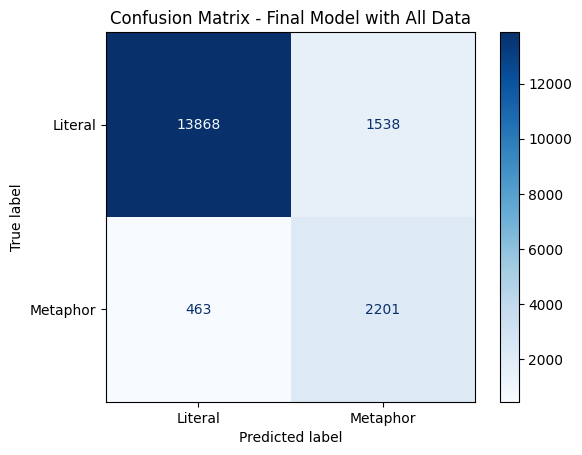

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_true_clean, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Literal', 'Metaphor'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model with All Data")
plt.show()

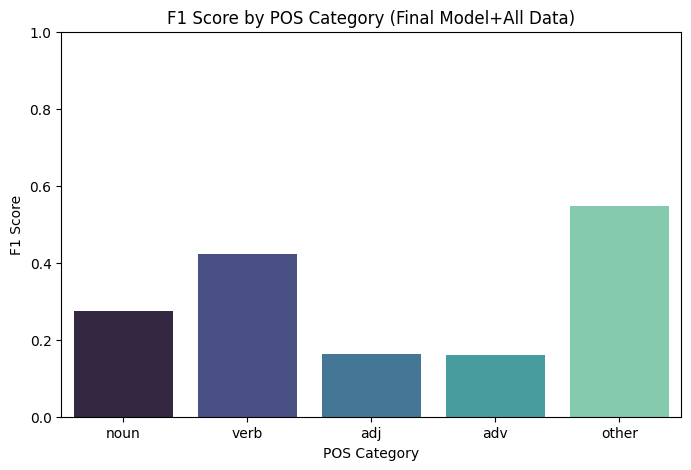

In [39]:
# # F1 Score by POS Category
# Prepare data for plotting
pos_labels = ['noun', 'verb', 'adj', 'adv', 'other']
f1_scores = []
for pos in pos_labels:
    comparison_mask = np.array([p == pos or p == 'na' for p in aligned_pos_clean])
    if comparison_mask.sum() > 0:
        y_true_sub = y_true_clean[comparison_mask]
        y_pred_sub = y_pred_clean[comparison_mask]
        f1 = precision_recall_fscore_support(y_true_sub, y_pred_sub, average=None, zero_division=0)[2]
        f1_scores.append(f1[1] if len(f1) > 1 else 0.0)
    else:
        f1_scores.append(0.0)
df_f1 = pd.DataFrame({'POS': pos_labels, 'F1 Score': f1_scores})
plt.figure(figsize=(8, 5))
sns.barplot(x='POS', y='F1 Score', data=df_f1, palette='mako')
plt.title('F1 Score by POS Category (Final Model+All Data)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.xlabel('POS Category')
plt.show()